# Copyright

<PRE>
Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2020 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu)
</PRE>

# Konvolúciós neurális hálózatok - alapok
Jelen notebookban a konvolúciós hálók használatának alapjaival ismerkedünk meg. Az itteni példa publikusan elérhető kép adatbázisok két dimenziós konvolúciós hálózattal történő feldolgozásáról fog szólni. Fontos megjegyezni, hogy ahogy a konvolúciós hálók felhasználása ma már sokkal bővebb, mint pusztán képfelismerés, szinte bármilyen tématerületen sikeresen alkalmazzák (pl. beszéd, hang, idősorok, játék botok, stb.).

Az első példánkban Yann LeCunn professzor MNIST kézzel írott szám adatbázisát fogjuk betanítani a hálóval. Az adatbázis elérhető publikusan: http://yann.lecun.com/exdb/mnist/
Illetve szinte mindegyik nagyobb deep learning frameworkben be lehet tölteni parancssorból. A mostani példában előbb a Keras-t fogjuk használni, majd a Tensorflow 2.0 Keras interfészét. Az adatokat is a Keras-on keresztül töltjük be:

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [2]:
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

batch_size=128

A tanítás előtt kapcsoljuk be a GPU-t Colab alatt (Runtime/Change runtime type). Ezután létrehozunk egy egyszerű modellt softmax aktivációs függvénnyel és betanítjuk batch_size batch mérettel:

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Embedding
from tensorflow.keras.optimizers import SGD

model = Sequential() 
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1,))) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(16, (5, 5), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) 

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [4]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)
# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
checkpointer=ModelCheckpoint(filepath='model.hdf5', save_best_only=True, verbose=1)
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

network_history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.2, callbacks=[early_stopping, checkpointer, tb])

Epoch 1/30
  1/375 [..............................] - ETA: 0s - loss: 2.3212 - accuracy: 0.0859WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
362/375 [===========================>..] - ETA: 0s - loss: 0.5927 - accuracy: 0.8097
Epoch 00001: val_loss improved from inf to 0.12425, saving model to model.hdf5
375/375 [==============================] - 2s 5ms/step - loss: 0.5800 - accuracy: 0.8140 - val_loss: 0.1242 - val_accuracy: 0.9632
Epoch 2/30
375/375 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9378
Epoch 00002: val_loss improved from 0.12425 to 0.09356, saving model to model.hdf5
375/375 [==============================] - 2s 4ms/step - loss: 0.2042 - accuracy: 0.9378 - val_loss: 0.0936 - val_accuracy: 0.9714
Epoch 3/30
361/375 [==

Ezután visszatöltjük a legjobb modellt és teszteljük:

In [6]:
from keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(x_test,y_test)
print("Teszt hiba:", test_err[0], "Teszt pontosság:", test_err[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0234 - accuracy: 0.9922
Teszt hiba: 0.023425737395882607 Teszt pontosság: 0.9922000169754028


## Metrikák, tévesztési mátrix
Nézzük először, hogy hogyan tudjuk kiszámolni az osztályozáshoz tartozó legfontosabb metrikákat és hogyan tudjuk megjeleníteni a konfúziós mátrixot:

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
# először is nyerjük ki a predikciókat (valószínüség és hozzá tartozó pontosságot)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,1)
y_true = np.argmax(y_test,1)

print("test accuracy: %g" %(accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))
print("\nKonfúziós mátrix: ")
conf=confusion_matrix(y_true, y_pred)
print(conf)

test accuracy: 0.9922
Precision 0.9921511176445845
Recall 0.9921018898612195
f1_score 0.9921176409348658

Konfúziós mátrix: 
[[ 976    0    1    0    0    0    2    1    0    0]
 [   0 1130    1    2    0    0    0    2    0    0]
 [   1    0 1027    1    1    0    0    2    0    0]
 [   0    0    1 1005    0    3    0    1    0    0]
 [   0    0    0    0  976    0    0    1    1    4]
 [   1    0    0    8    0  881    1    1    0    0]
 [   4    1    0    0    1    2  949    0    1    0]
 [   0    2    2    1    1    0    0 1021    0    1]
 [   0    0    2    1    0    3    0    1  966    1]
 [   0    0    0    0    6    3    0    7    2  991]]


A tévesztési mátrixot vizuálisan is érdemes vizsgálni:

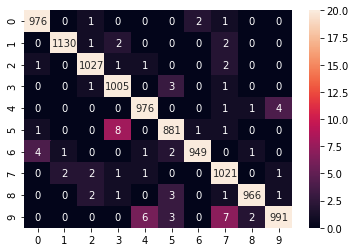

In [8]:
import seaborn as sns
sns.heatmap(conf, annot=True, fmt='d', vmax=20) # a vmax paraméterrel állítjuk be, hogy milyen értéktartományban jelenítse meg az adatokat

Fontos felhívni a figyelmet a precision, recall és f1 esetén az "avarage" paraméterre. Mivel ezek a metrikák alapvetően két osztályt vesznek figyelembe, ezért több lehetőségünk van több osztálynál az értékek figyelembe vételére. Ennek talán legegyszerűbb módja a "macro", amikor minden osztálynál kiszámolt érték átlagát veszi. Ha "micro"-ra állítjuk, akkor összegzi az összes osztály esetén a TP, TN, FN, FP értékeket és ezekkel számol. "weighted" esetben pedig azt is figyelembe veszi, hogy melyik osztályban mennyi minta van, és amelyikbe sok, azt nagyobb súllyal veszi figyelembe. 

# Adatok és aktivációk vizsgálata TensorBoard projectorban


In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# a modell bemenetének megadása
inp = model.input              
# a modell összes kimenetének a listázása                             
outputs = [layer.output for layer in model.layers]
print(outputs)

[<tf.Tensor 'conv2d/Relu_1:0' shape=(None, 24, 24, 6) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool_1:0' shape=(None, 12, 12, 6) dtype=float32>, <tf.Tensor 'conv2d_1/Relu_1:0' shape=(None, 8, 8, 16) dtype=float32>, <tf.Tensor 'max_pooling2d_1/MaxPool_1:0' shape=(None, 4, 4, 16) dtype=float32>, <tf.Tensor 'dropout/cond_1/Identity:0' shape=(None, 4, 4, 16) dtype=float32>, <tf.Tensor 'flatten/Reshape_1:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'dense/Relu_1:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'dropout_1/cond_1/Identity:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'dense_1/Softmax_1:0' shape=(None, 10) dtype=float32>]


Létrehozunk két almodellt, melyek kimenete az adott rétegek kimenete:

In [10]:
submodel_1 = Model(inp, outputs[0])
submodel_2 = Model(inp, outputs[5])

Ezt követően a teszt adatbázis 500 mintájával csinálunk egy-egy predikciót és külön tensor-okba mentünk el:

In [11]:
X_test500 = x_test[:500]
Y_test500 = y_test[:500]

In [12]:
pred_1 = submodel_1.predict(X_test500)
pred_2 = submodel_2.predict(X_test500)

Ezt követően pedig a nyers adatokat és a réteg aktivációkat kiírjuk a TensorBoard Projektor számára. Ehhez a TensorBoardX csomagot fogjuk használni, amit telepíteni kell:

In [13]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 11.2MB/s 


In [14]:
logdir = 'logs/'
from tensorboardX import SummaryWriter

with SummaryWriter(logdir+'/projector/raw_data') as w:
  w.add_embedding(X_test500.reshape(500,-1), metadata=np.argmax(Y_test500,1), label_img=X_test500.reshape(500,1,28,28), global_step=0)

with SummaryWriter(logdir+'/projector/submodel_1') as w:
  w.add_embedding(pred_1.reshape(500,-1), metadata=np.argmax(Y_test500,1), label_img=X_test500.reshape(500,1,28,28), global_step=0)

with SummaryWriter(logdir+'/projector/submodel_2') as w:
  w.add_embedding(pred_2.reshape(500,-1), metadata=np.argmax(Y_test500,1), label_img=X_test500.reshape(500,1,28,28), global_step=0)


Végül pedig vizsgáljuk meg TensorBoard-ban a beágyazásokat. Ha esetleg a Projector menüpont nem jelenik meg, akkor az inactive menük közül válaszd ki:

In [15]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs